In [25]:
import sys
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Lambda, dot, Activation, concatenate,  Layer, Embedding, Bidirectional
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback

In [26]:
dftweets = pd.read_csv('F:/ASDRP/stocktwits_AAPL.csv')
dftweets = dftweets.replace('N/A\n', np.nan)
dftweets = dftweets.replace('N/A', np.nan)
dftweets = dftweets.replace('1\n', 1)
dftweets = dftweets.replace('0\n', 0)
dftweets = dftweets.replace('1', 1)
dftweets = dftweets.replace('0', 0)
dftweets = dftweets.dropna()
#dftweets = dftweets[(dftweets['datetime']>= "2020-01-01") & (dftweets['datetime']< "2021-01-01")]
dftweets = dftweets.drop_duplicates('message_id')
dftweets.head()
dftweets.shape

(239729, 6)

In [27]:
dftweets.sentiment.value_counts()

1.0    176740
0.0     62989
Name: sentiment, dtype: int64

In [28]:
from sklearn.utils import resample
RANDOM_SEED = 42
bullish = dftweets[dftweets.sentiment == 1]
bearish = dftweets[dftweets.sentiment == 0 ]
bullish_downsampled = resample(bullish, replace = False, n_samples = len(dftweets[dftweets['sentiment'] == 0]), random_state = RANDOM_SEED)
dftweets = pd.concat([bearish, bullish_downsampled])
dftweets.sentiment.value_counts()

1.0    62989
0.0    62989
Name: sentiment, dtype: int64

In [29]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import string 

def processTweet(tweet):
    tweet = re.sub(r'\&\w*;', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#\w*', '', tweet)
    tweet = re.sub(r'$\w*', '', tweet)
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = tweet.lstrip(' ') 
    tweet = re.sub('https', ' ', tweet)
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

x = list(dftweets['message'])
for i in range(0,len(x)):
  x[i] = processTweet(x[i])

dftweets['message'] = x

tokenizer = RegexpTokenizer(r'\w+')
regexptokenized = []
for i in list(dftweets['message']):
  regexptokenized.append(tokenizer.tokenize(i))
#tokenizedcontent = tokenizer.tokenize(list(dftweets['content']))
print(regexptokenized[0:5])
tokenized = []


filtered_words = [word for word in regexptokenized if word not in stopwords.words('english')]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[['smartoptions', 'unusual', 'activity', 'alert', 'delayed', 'puts', '2021', 'exp', 'trade', 'volume', '730', 'contracts', '092', '000', 'was', 'traded', 'now', 'current', 'stock', 'price', 'trade', 'type', 'split', 'follow', 'the', 'money', 'trade', 'options', 'with', 'our', 'smartoptions', 'artificial', 'intelligence', 'www', 'smartoptions'], ['smartoptions', 'unusual', 'activity', 'alert', 'delayed', 'puts', '2021', 'exp', 'trade', 'volume', '735', 'contracts', '374', '225', 'was', 'traded', 'now', 'current', 'stock', 'price', 'trade', 'type', 'sweep', 'follow', 'the', 'money', 'trade', 'options', 'with', 'our', 'smartoptions', 'artificial', 'intelligence', 'www', 'smartoption

In [30]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
stringcontent = ""
newcontent = []
for i in filtered_words:
  stringcontent = ""
  for j in i:
    stringcontent += lemmatizer.lemmatize(j) + " " 
  
  newcontent.append(stringcontent)
dftweets['Content'] = newcontent

In [31]:
dftweets

,symbol,message,datetime,user,message_id,sentiment,Content
6,AAPL,smartoptions® unusual activity alert delayed p...,2021-01-02T01:07:40Z,1712113,268974913,0.0,smartoptions unusual activity alert delayed pu...
7,AAPL,smartoptions® unusual activity alert delayed p...,2021-01-02T01:01:25Z,4068309,268974356,0.0,smartoptions unusual activity alert delayed pu...
10,AAPL,smartoptions® unusual activity alert delayed p...,2021-01-02T00:42:50Z,4068309,268972750,0.0,smartoptions unusual activity alert delayed pu...
11,AAPL,where the uyghur outrage from you bleeding hea...,2021-01-02T00:41:31Z,1435301,268972647,0.0,where the uyghur outrage from you bleeding hea...
12,AAPL,this company the biggest china supporter any c...,2021-01-02T00:35:39Z,1435301,268972098,0.0,this company the biggest china supporter any c...
...,...,...,...,...,...,...,...
316566,AAPL,while back compared opening penny stocks posit...,2020-07-09T02:36:01Z,1467930,226347330,1.0,while back compared opening penny stock positi...
422049,AAPL,supplier foxconn expects coronavirus hit labor...,2020-03-04T04:28:24Z,618049,198092220,1.0,supplier foxconn expects coronavirus hit labor...
208545,AAPL,bff,2020-09-04T19:17:30Z,3420354,241950120,1.0,bff
143532,AAPL,look bears coming with every single excuse wha...,2020-09-28T13:20:46Z,3355717,246672558,1.0,look bear coming with every single excuse what...


In [32]:
epochs = 10
embed_size = 200
batch_size = 16
maxlen = 75
vocab_size = 35000

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
EMBEDDING_FILE = 'F:/ASDRP/src/models/textclassification/glove.twitter.27B.200d.txt'
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf8" ))

In [35]:
from sklearn.model_selection import train_test_split
X = dftweets.Content.values 
y = dftweets.sentiment.values
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen = maxlen)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [36]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(vocab_size, len(word_index)) + 1
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i > vocab_size: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [37]:
embedding_matrix.shape

(33755, 200)

In [38]:
class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [39]:
epochs = 10
embed_size = 200
batch_size = 16

In [40]:
model = Sequential()
model.add(Embedding(nb_words, output_dim=embed_size, input_length= maxlen, weights = [embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(units=128)))
#model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
METRICS = [
      tensorflow.keras.metrics.TruePositives(name='tp'),
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.TrueNegatives(name='tn'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'),
      tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
      tensorflow.keras.metrics.Precision(name='precision'),
      tensorflow.keras.metrics.Recall(name='recall'),
      tensorflow.keras.metrics.AUC(name='auc'),
]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [41]:
my_callback = MyThresholdCallback(threshold=0.75)
history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_test, y_test) , epochs = 3, callbacks = [my_callback])

Epoch 1/3
5512/5512 [==============================] - 339s 60ms/step - loss: 0.6175 - tp: 15078.8587 - fp: 7668.4308 - tn: 14414.5502 - fn: 6950.1545 - accuracy: 0.6478 - precision: 0.6434 - recall: 0.6611 - auc: 0.7072 - val_loss: 0.5349 - val_tp: 14431.0000 - val_fp: 5868.0000 - val_tn: 12983.0000 - val_fn: 4512.0000 - val_accuracy: 0.7254 - val_precision: 0.7109 - val_recall: 0.7618 - val_auc: 0.8055
Epoch 2/3
5512/5512 [==============================] - 312s 57ms/step - loss: 0.5040 - tp: 16929.2137 - fp: 6133.3046 - tn: 15941.8585 - fn: 5107.6174 - accuracy: 0.7454 - precision: 0.7346 - recall: 0.7681 - auc: 0.8299 - val_loss: 0.5100 - val_tp: 14417.0000 - val_fp: 5276.0000 - val_tn: 13575.0000 - val_fn: 4526.0000 - val_accuracy: 0.7406 - val_precision: 0.7321 - val_recall: 0.7611 - val_auc: 0.8257
Epoch 3/3
4240/5512 [======================>.......] - ETA: 1:07 - loss: 0.4507 - tp: 13592.4210 - fp: 4209.0259 - tn: 12778.6231 - fn: 3347.9300 - accuracy: 0.7767 - precision: 0.7623

In [67]:
#model.save('modelGLOVE7114.h5')

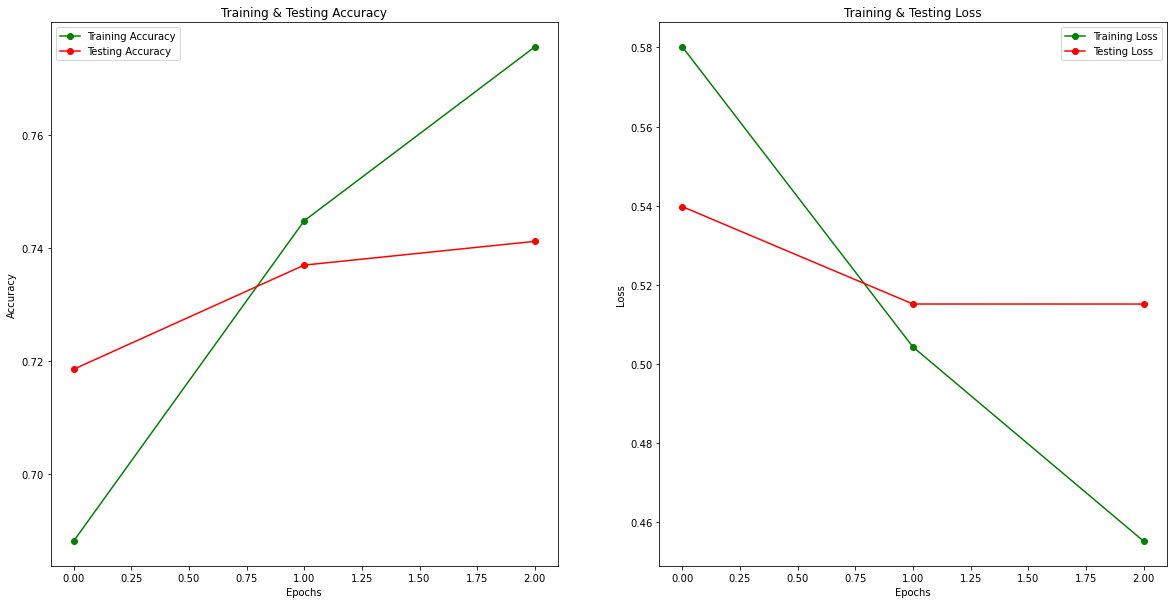

In [20]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 75, 200)           6534200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,871,353
Trainable params: 337,153
Non-trainable params: 6,534,200
_________________________________________________________________


In [22]:
predicted = (model.predict(X_test) >= 0.5).astype("int")

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74     17699
         1.0       0.74      0.75      0.74     17752

    accuracy                           0.74     35451
   macro avg       0.74      0.74      0.74     35451
weighted avg       0.74      0.74      0.74     35451



<AxesSubplot:>

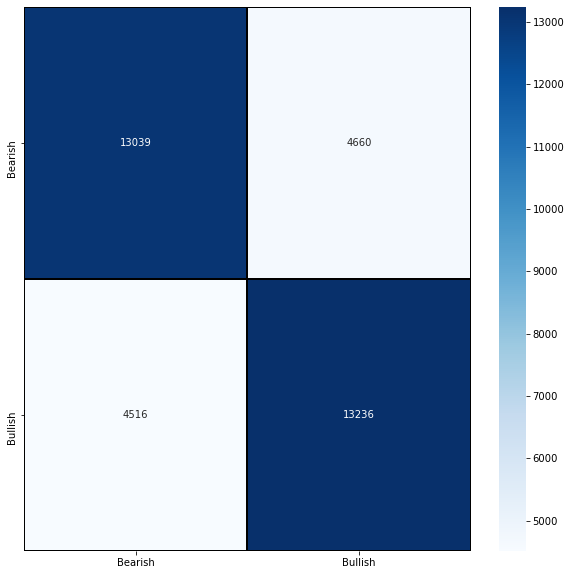

In [24]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predicted)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['Bearish','Bullish'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bearish','Bullish'] , yticklabels = ['Bearish','Bullish'])

In [103]:
xna = pd.read_csv('F:/ASDRP/data/stocktwits_SPXclassified2.csv')
xna = xna[xna['sentiment'].isna()]

In [104]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import string 

#word_vectors = w2v_model.wv

def processTweet(tweet):
    tweet = re.sub(r'\&\w*;', '', tweet)
    tweet = re.sub('@[^\s]+','',tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    tweet = re.sub(r'#\w*', '', tweet)
    tweet = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', tweet)
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    tweet = tweet.lstrip(' ') 
    tweet = re.sub('https', ' ', tweet)
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

x = list(xna['message'])
for i in range(0,len(x)):
  x[i] = processTweet(x[i])

xna['Content'] = x

tokenizer = RegexpTokenizer(r'\w+')
regexptokenized = []
for i in list(xna['Content']):
  regexptokenized.append(tokenizer.tokenize(i))
#tokenizedcontent = tokenizer.tokenize(list(dftweets['content']))
print(regexptokenized[0:5])
tokenized = []


filtered_words = [word for word in regexptokenized if word not in stopwords.words('english')]
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
stringcontent = ""
newcontent = []
for i in filtered_words:
    stringcontent = ""
    for j in i:
        if j in word_index.keys():
            stringcontent += lemmatizer.lemmatize(j) + " "
        else:
            stringcontent += " "
    newcontent.append(stringcontent)
xna['Content'] = newcontent

X2 = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in xna["Content"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X2.append(tmp)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emu4y\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[['עליות', 'קלות', 'אופטימיות', 'קלה', 'הסקירה', 'היום', 'שהיה', 'מאת', 'haim', 'baran', 'עליות', 'קלות', 'אווירת', 'סוף', 'עונה', 'אופטימיות', 'קלה'], ['500', 'stocks', 'day', 'high', 'dec', 'day', 'day', 'day', 'indexindicators', 'com'], ['500', 'stocks', 'day', 'high', 'dec', 'day', 'day', 'day', 'indexindicators', 'com'], ['going', 'into', 'january', 'note', 'fang', 'lack', 'participation', 'worries', 'ned', 'davis', 'senior', 'investment', 'strategist', 'ned', 'davis', 'research', 'notes', 'that', 'the', '500', 'has', 'gained', '2020', 'but', 'only', 'half', 'that', 'without', 'the', 'six', 'stocks', 'which', 'group', 'peaked', 'sept', 'they', 'have', 'refused', 'confirm', '

In [105]:
# word_index = {w: i for i, w in enumerate(embeddings_index.keys(), 1)}
# from keras.preprocessing.text import text_to_word_sequence
# def texts_to_sequences(texts,word_index):
#     for text in texts:
#         tokens = text_to_word_sequence(text)
#         yield [word_index.get(w) for w in tokens if w in word_index]
# sequence = texts_to_sequences(X2, word_index)
# sequence = pad_sequences(sequence, maxlen = maxlen)

In [106]:
# pred2 = (model.predict(sequence) >= 0.5).astype("int")

In [107]:
t = Tokenizer()
t.fit_on_texts(X2)

X2 = t.texts_to_sequences(X2)
X2 = pad_sequences(X2, maxlen=maxlen)

In [108]:
pred2 = (model.predict(X2) >= 0.5).astype("int")

In [109]:
xna['sentiment'] = pred2
xna

,Unnamed: 0,symbol,message,datetime,user,message_id,sentiment,Content
0,1,SPX,$SPX עליות קלות - אופטימיות קלה. הסקירה- היום...,2020-12-25T06:44:13Z,1820165,267252252,1,
1,2,SPX,S&amp;P 500 Stocks At X-Day High [24-Dec]:\n\n...,2020-12-25T03:49:48Z,313661,267243764,1,500 day high dec day day day com
2,3,SPX,S&amp;P 500 Stocks At X-Day High [24-Dec]:\n\n...,2020-12-25T01:49:36Z,313661,267235311,1,500 day high dec day day day com
4,5,SPX,"$SPX $SPY Going into January... Note,\nFANG’s ...",2020-12-25T00:13:53Z,1339265,267227256,0,going into january note fang lack participatio...
5,6,SPX,"$SPX $ES_F $SPY Daily Charts… E-Mini, A/D - ...",2020-12-24T23:59:43Z,379101,267225894,1,daily mini vol rsi www com 500 daily html
...,...,...,...,...,...,...,...,...
162439,162440,SPX,$SPX finally dat faqin 2792,2019-02-22T16:21:01Z,851303,154653768,0,finally dat 2792
162441,162442,SPX,$VIX $SPY $ES_F $SPX VIX Update - Emini Bears ...,2019-02-22T16:14:45Z,1787124,154652286,1,vix update emini can home unless they can tak...
162442,162443,SPX,$SPY $SPX $QQQ $DIA $IWM $VIX $VXX $VXST $VIXY...,2019-02-22T16:11:05Z,868373,154651439,1,your chart meaningless
162443,162444,SPX,$SPY $SPX $QQQ $DIA $IWM $VIX $VXX $VXST $VIXY...,2019-02-22T16:10:40Z,868373,154651330,1,dude who show your trading log everyone


In [110]:
x3 = pd.concat([dftweets, xna])
x3.shape

(156983, 8)

In [112]:
x3.to_csv('Stocktwits_SPXClassified3_2.csv')